In [1]:
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
from torchvision import transforms
from torchvision import models
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import Dataset,DataLoader
import time
%matplotlib inline

In [2]:

def imshow(inp,cmap=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp,cmap)
   

## Check if GPU is present

In [3]:
is_cuda = False
if torch.cuda.is_available():
    is_cuda = True

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load data into PyTorch tensors

In [121]:
path = '../image_data/data/dogscats/'

In [122]:
simple_transform = transforms.Compose([transforms.Resize((224,224))
                                       ,transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])
train = ImageFolder(path+'train/',simple_transform)
valid = ImageFolder(path+'valid/',simple_transform)

In [123]:
print(train.class_to_idx)
print(train.classes) 


{'cats': 0, 'dogs': 1}
['cats', 'dogs']


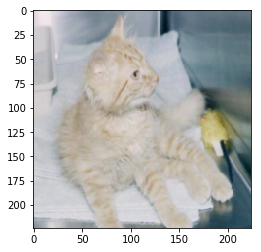

In [124]:
imshow(valid[770][0])

## Create data generators

In [125]:
train_data_loader = torch.utils.data.DataLoader(train,batch_size=32,num_workers=3,shuffle=True)
valid_data_loader = torch.utils.data.DataLoader(valid,batch_size=32,num_workers=3,shuffle=True)

In [126]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(56180, 500)
        self.fc2 = nn.Linear(500,50)
        self.fc3 = nn.Linear(50, 2)

    def forward(self, x):
        #shape x: torch.Size([32, 3, 224, 224])
        x = self.conv1(x)
        #note as we are not padding we loose edges
        #post conv1(x): torch.Size([32, 10, 220, 220])
        x = F.relu(F.max_pool2d(x, 2))
        #post max pool x: torch.Size([32, 10, 110, 110])
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #post conv2 x: torch.Size([32, 20, 53, 53])
        x = x.view(x.size(0), -1)
        #post view x: torch.Size([32, 56180])
        x = F.relu(self.fc1(x))
        #post fc1 x: torch.Size([32, 500])
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        #post fc2 x: torch.Size([32, 50])
        x = F.dropout(x,training=self.training)
        x = self.fc3(x)
        #post fc3 x: torch.Size([32, 2])
        return F.log_softmax(x,dim=1)

In [127]:
model = Net()
if is_cuda:
    model.to(device)

In [128]:
optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.5)

In [129]:
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.to(device),target.to(device)
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output,target)
        
        running_loss += F.nll_loss(output,target,size_average=False).item()
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = float(running_loss/len(data_loader.dataset))
    accuracy = float(100. * running_correct/len(data_loader.dataset))
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [130]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,20):
    epoch_loss, epoch_accuracy = fit(epoch,model,train_data_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model,valid_data_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is  0.67 and training accuracy is 13445/23000      58.0
validation loss is  0.65 and validation accuracy is 1272/2000      63.0
training loss is  0.63 and training accuracy is 14917/23000      64.0
validation loss is  0.59 and validation accuracy is 1375/2000      68.0
training loss is  0.59 and training accuracy is 15714/23000      68.0
validation loss is  0.54 and validation accuracy is 1440/2000      72.0
training loss is  0.56 and training accuracy is 16303/23000      70.0
validation loss is  0.53 and validation accuracy is 1463/2000      73.0
training loss is  0.53 and training accuracy is 16928/23000      73.0
validation loss is   0.5 and validation accuracy is 1515/2000      75.0
training loss is   0.5 and training accuracy is 17471/23000      75.0
validation loss is  0.48 and validation accuracy is 1515/2000      75.0
training loss is  0.47 and training accuracy is 17960/23000      78.0
validation loss is  0.48 and validation accuracy is 1530/2000      76.0
traini

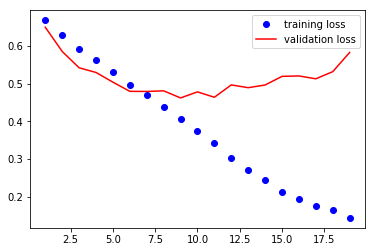

In [131]:
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

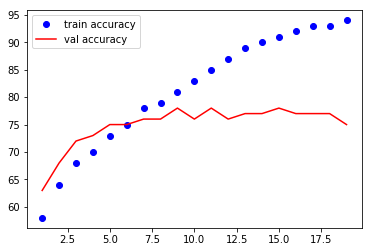

In [132]:
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()

## Transfer learning using VGG

In [136]:
vgg = models.vgg16(pretrained=True)
vgg = vgg.to(device)

### Print VGG

In [137]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

## Freeze layers

In [138]:
vgg.classifier[6].out_features = 2
for param in vgg.features.parameters(): 
    param.requires_grad = False

In [139]:
optimizer = optim.SGD(vgg.classifier.parameters(),lr=0.0001,momentum=0.5)

In [140]:
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.to(device)
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output,target)
        
        running_loss += F.cross_entropy(output,target,size_average=False).item()
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = float(running_loss/len(data_loader.dataset))
    accuracy = float(100. * running_correct/len(data_loader.dataset))
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [141]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,vgg,train_data_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,vgg,valid_data_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is   3.2 and training accuracy is 13669/23000      59.0
validation loss is  0.22 and validation accuracy is 1893/2000      94.0
training loss is  0.17 and training accuracy is 21909/23000      95.0
validation loss is 0.098 and validation accuracy is 1941/2000      97.0
training loss is  0.11 and training accuracy is 22261/23000      96.0
validation loss is 0.073 and validation accuracy is 1952/2000      97.0
training loss is 0.088 and training accuracy is 22342/23000      97.0
validation loss is 0.063 and validation accuracy is 1957/2000      97.0
training loss is  0.08 and training accuracy is 22392/23000      97.0
validation loss is 0.056 and validation accuracy is 1961/2000      98.0
training loss is 0.072 and training accuracy is 22438/23000      97.0
validation loss is 0.052 and validation accuracy is 1965/2000      98.0
training loss is 0.064 and training accuracy is 22486/23000      97.0
validation loss is 0.048 and validation accuracy is 1968/2000      98.0
traini

### Adjusting dropout

In [142]:
for layer in vgg.classifier.children():
    if(type(layer) == nn.Dropout):
        layer.p = 0.2

In [143]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,3):
    epoch_loss, epoch_accuracy = fit(epoch,vgg,train_data_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,vgg,valid_data_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is 0.045 and training accuracy is 22647/23000      98.0
validation loss is 0.044 and validation accuracy is 1968/2000      98.0
training loss is 0.044 and training accuracy is 22661/23000      98.0
validation loss is 0.042 and validation accuracy is 1968/2000      98.0


### Data augmentation

In [144]:
path=('../image_data/data/dogscats/')

In [145]:
train_transform = transforms.Compose([transforms.Resize((224,224))
                                       ,transforms.RandomHorizontalFlip()
                                       ,transforms.RandomRotation(0.2)
                                       ,transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])
train = ImageFolder(path+'train/',train_transform)
valid = ImageFolder(path+'valid/',simple_transform)

In [146]:
train_data_loader = DataLoader(train,batch_size=32,num_workers=3,shuffle=True)
valid_data_loader = DataLoader(valid,batch_size=32,num_workers=3,shuffle=True)

In [147]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,3):
    epoch_loss, epoch_accuracy = fit(epoch,vgg,train_data_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,vgg,valid_data_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is 0.045 and training accuracy is 22639/23000      98.0
validation loss is 0.041 and validation accuracy is 1968/2000      98.0
training loss is 0.042 and training accuracy is 22650/23000      98.0
validation loss is 0.041 and validation accuracy is 1969/2000      98.0


## Calculating preconvoluted features


In [148]:
vgg = models.vgg16(pretrained=True)
vgg = vgg.to(device)

In [149]:
features = vgg.features

In [150]:
for param in features.parameters(): 
    param.requires_grad = False

In [151]:
train_data_loader = torch.utils.data.DataLoader(train,batch_size=32,num_workers=3,shuffle=False)
valid_data_loader = torch.utils.data.DataLoader(valid,batch_size=32,num_workers=3,shuffle=False)

In [152]:
def preconvfeat(dataset,model):
    conv_features = []
    labels_list = []
    for data in dataset:
        inputs,labels = data
        if is_cuda:
            inputs , labels = inputs.cuda(),labels.to(device)      
        inputs , labels = Variable(inputs),Variable(labels)
        output = model(inputs)
        conv_features.extend(output.data.cpu().numpy())
        labels_list.extend(labels.data.cpu().numpy())
    conv_features = np.concatenate([[feat] for feat in conv_features])
    
    return (conv_features,labels_list)

In [153]:
conv_feat_train,labels_train = preconvfeat(train_data_loader,features)

In [154]:
conv_feat_val,labels_val = preconvfeat(valid_data_loader,features)

In [155]:
class My_dataset(Dataset):
    def __init__(self,feat,labels):
        self.conv_feat = feat
        self.labels = labels
    
    def __len__(self):
        return len(self.conv_feat)
    
    def __getitem__(self,idx):
        return self.conv_feat[idx],self.labels[idx]

In [156]:
train_feat_dataset = My_dataset(conv_feat_train,labels_train)
val_feat_dataset = My_dataset(conv_feat_val,labels_val)

In [157]:
train_feat_loader = DataLoader(train_feat_dataset,batch_size=64,shuffle=True)
val_feat_loader = DataLoader(val_feat_dataset,batch_size=64,shuffle=True)

In [158]:
def data_gen(conv_feat,labels,batch_size=64,shuffle=True):
    labels = np.array(labels)
    if shuffle:
        index = np.random.permutation(len(conv_feat))
        conv_feat = conv_feat[index]
        labels = labels[index]
    for idx in range(0,len(conv_feat),batch_size):
        yield(conv_feat[idx:idx+batch_size],labels[idx:idx+batch_size])

In [159]:
train_batches = data_gen(conv_feat_train,labels_train)
val_batches = data_gen(conv_feat_val,labels_val)

In [160]:
optimizer = optim.SGD(vgg.classifier.parameters(),lr=0.0001,momentum=0.5)

In [180]:
def fit_numpy(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        data = data.view(data.size(0), -1)
        output = model(data)
        loss = F.cross_entropy(output,target)
        
        running_loss += F.cross_entropy(output,target,size_average=False).item()
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = float(running_loss/len(data_loader.dataset))
    accuracy = float(100. * running_correct/len(data_loader.dataset))
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [ ]:
%%time
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,20):
    epoch_loss, epoch_accuracy = fit_numpy(epoch,vgg.classifier,train_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit_numpy(epoch,vgg.classifier,val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is 1.8e+01 and training accuracy is 0/23000       0.0
validation loss is 1.7e+01 and validation accuracy is 0/2000       0.0


## Visualizing intermediate CNN layers

In [163]:
train_data_loader = torch.utils.data.DataLoader(train,batch_size=32,num_workers=3,shuffle=False)
img,label = next(iter(train_data_loader))

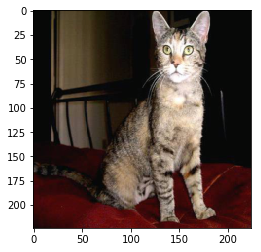

In [164]:
imshow(img[5])

In [165]:
img = img[5][None]

In [166]:
vgg = models.vgg16(pretrained=True).cuda()

In [167]:
class LayerActivations():
    features=None
    
    def __init__(self,model,layer_num):
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)
    
    def hook_fn(self,module,input,output):
        self.features = output.cpu().data.numpy()
    
    def remove(self):
        self.hook.remove()
        

conv_out = LayerActivations(vgg.features,0)

o = vgg(Variable(img.cuda()))

conv_out.remove()

In [168]:
act = conv_out.features

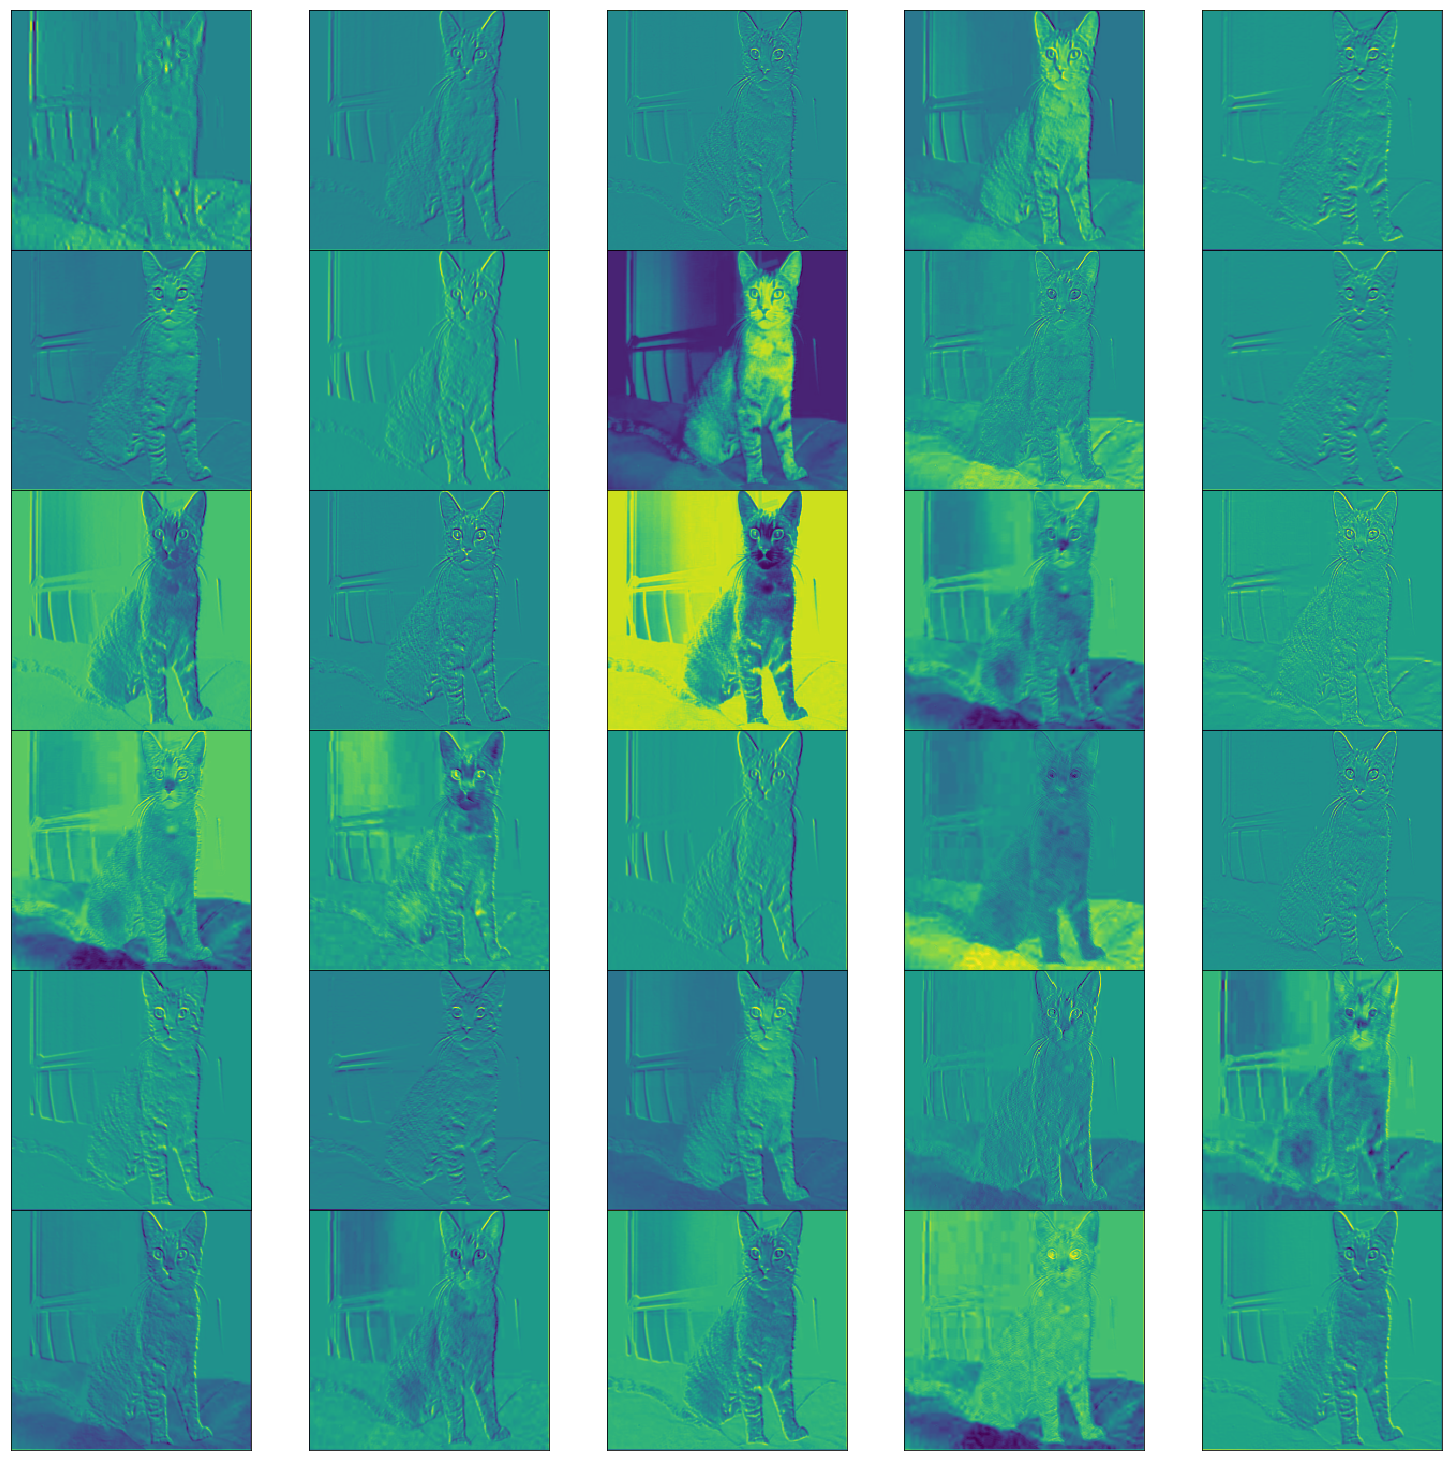

In [169]:
fig = plt.figure(figsize=(20,50))
fig.subplots_adjust(left=0,right=1,bottom=0,top=0.8,hspace=0,wspace=0.2)
for i in range(30):
    ax = fig.add_subplot(12,5,i+1,xticks=[],yticks=[])
    ax.imshow(act[0][i])

In [170]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

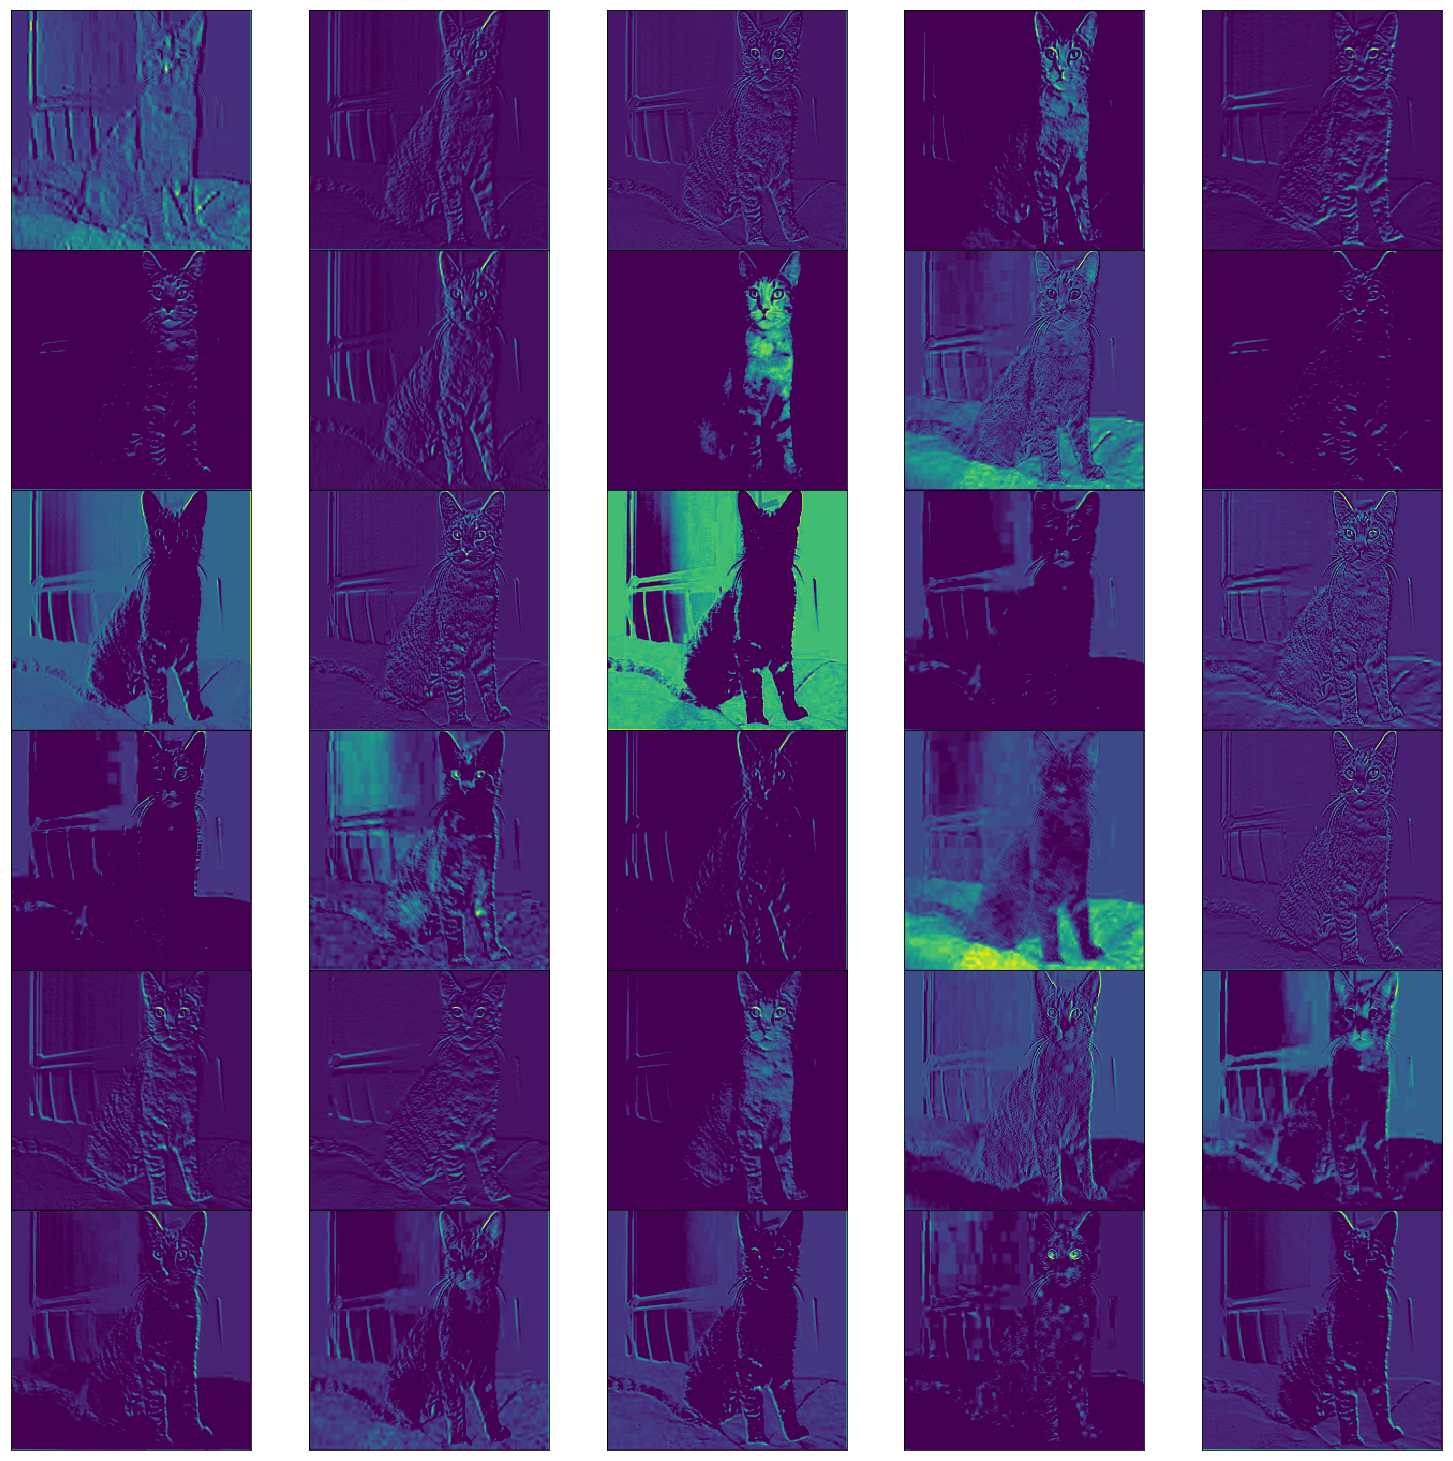

In [171]:
conv_out = LayerActivations(vgg.features,1)

o = vgg(Variable(img.to(device)))

conv_out.remove()

act = conv_out.features

fig = plt.figure(figsize=(20,50))
fig.subplots_adjust(left=0,right=1,bottom=0,top=0.8,hspace=0,wspace=0.2)
for i in range(30):
    ax = fig.add_subplot(12,5,i+1,xticks=[],yticks=[])
    ax.imshow(act[0][i])

In [172]:
def imshow(inp):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

In [173]:
conv_out = LayerActivations(vgg.features,1)

o = vgg(Variable(img.to(device)))

conv_out.remove()

act = conv_out.features

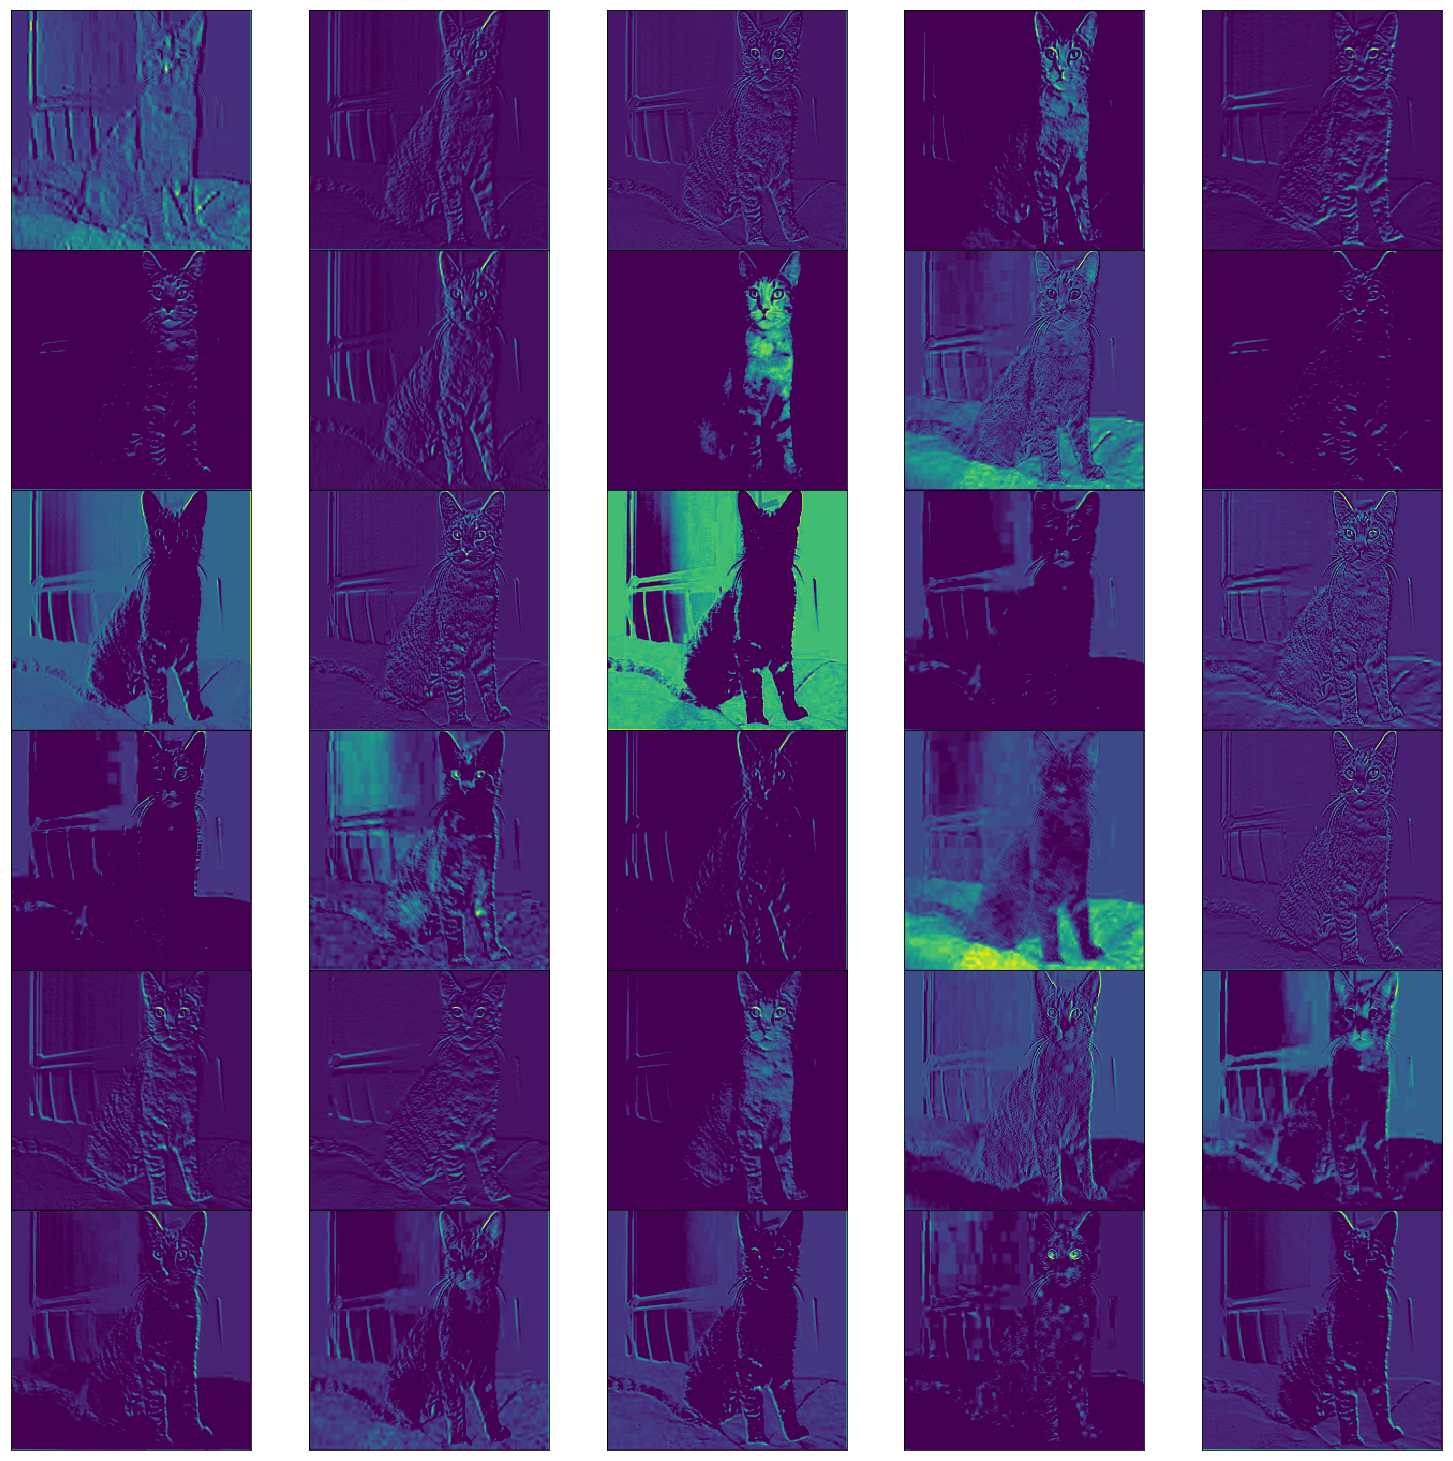

In [174]:
fig = plt.figure(figsize=(20,50))
fig.subplots_adjust(left=0,right=1,bottom=0,top=0.8,hspace=0,wspace=0.2)
for i in range(30):
    ax = fig.add_subplot(12,5,i+1,xticks=[],yticks=[])
    ax.imshow(act[0][i])

## Visualizing weights

In [175]:
vgg = models.vgg16(pretrained=True).to(device)

In [176]:
vgg.state_dict().keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias'])

In [177]:

cnn_weights = vgg.state_dict()['features.0.weight'].cpu()

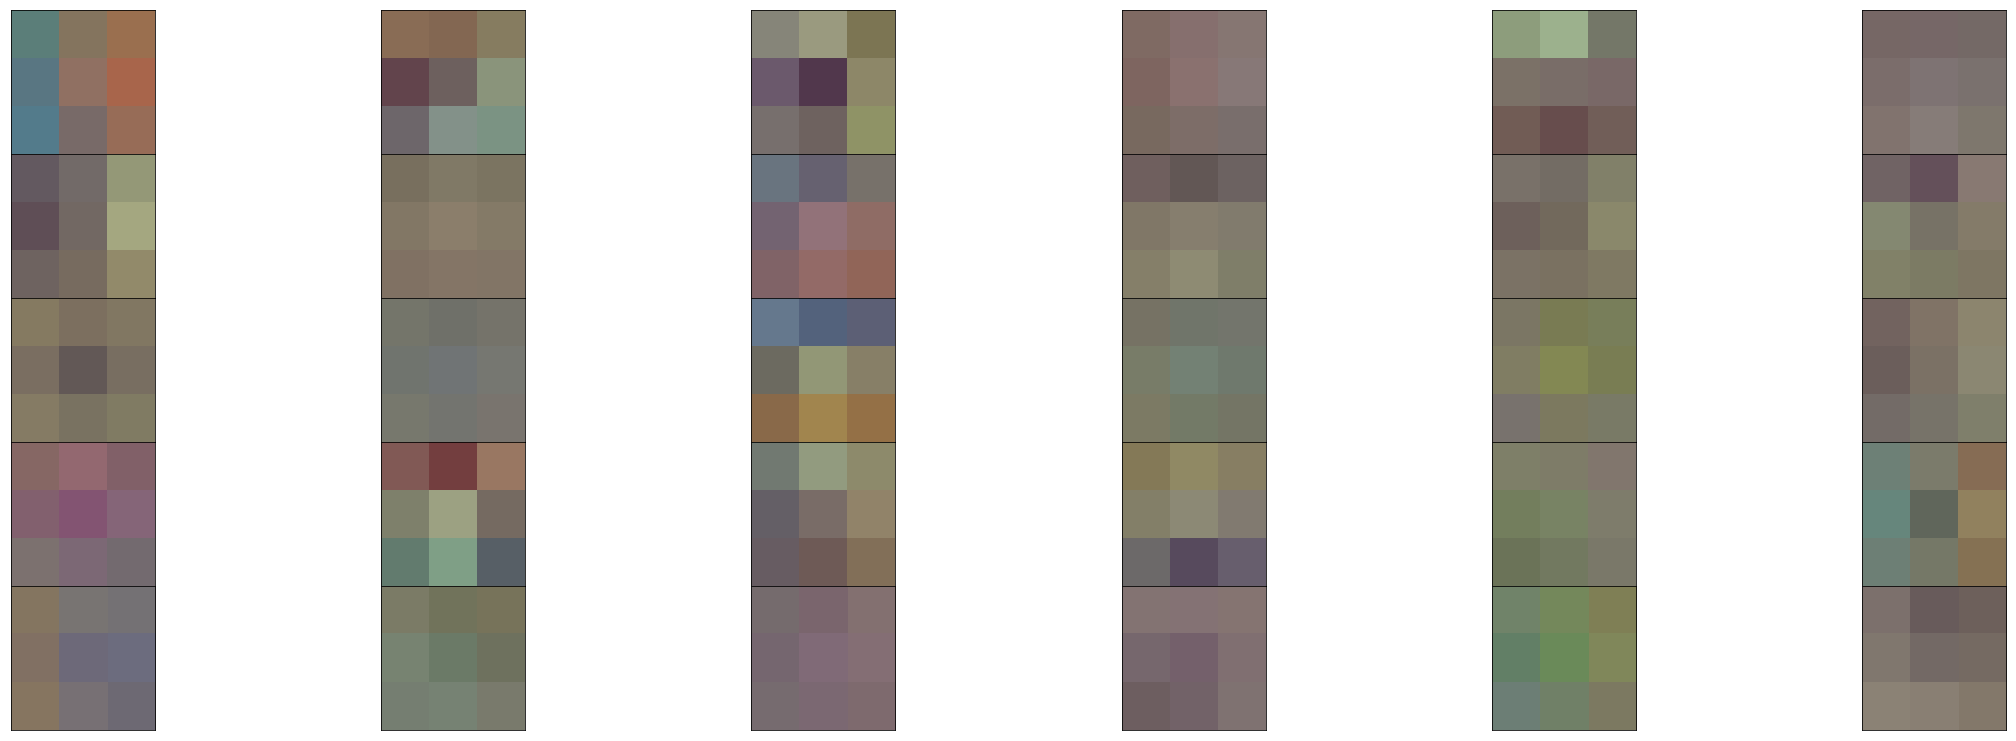

In [178]:
fig = plt.figure(figsize=(30,30))
fig.subplots_adjust(left=0,right=1,bottom=0,top=0.8,hspace=0,wspace=0.2)
for i in range(30):
    ax = fig.add_subplot(12,6,i+1,xticks=[],yticks=[])
    imshow(cnn_weights[i])

In [179]:
cnn_weights.shape

torch.Size([64, 3, 3, 3])